In [60]:
import geopandas as gpd
import pandas as pd
import fiona
import matplotlib.pyplot as plt
from shapely.geometry import Point
from tqdm import tqdm
import rasterio
import numpy as np
import yaml
import os

# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

#### Prep the groundwater productivity data

In [32]:
# Enable tqdm for Pandas apply function
tqdm.pandas()

# Load the data with a progress bar
df = pd.read_csv(resolve_path(config['Groundwater_Productivity_path']), sep=r'\s+')
print(df.head)

# Create geometry for coordinates with a progress bar
geometry = [Point(xy) for xy in tqdm(zip(df.X, df.Y), desc="Creating geometries")]
gdf = gpd.GeoDataFrame(df, geometry=geometry)
gdf.set_crs(epsg=4326, inplace=True)

# Rename column 'GWPROD_V2'
gdf.rename(columns={'GWPROD_V2': 'Liters_Second'}, inplace=True)

# Reassign values with a progress bar
value_map = {'VH': 20.0, 'H': 12.5, 'M': 3.0, 'LM': 0.75, 'L': 0.3, 'VL': 0.1}
gdf['Liters_Second'] = gdf['Liters_Second'].progress_apply(lambda x: value_map.get(x, x))

# Save file with a progress bar
with tqdm(total=len(gdf), desc="Saving file") as pbar:
    gdf.to_file(resolve_path(config['Groundwater_Prod_gpkg_path']), layer='groundwater', driver='GPKG')
    



<bound method NDFrame.head of                 X          Y GWPROD_V2
0         9.41405  37.251192         M
1         9.46405  37.251192         M
2         9.51405  37.251192         M
3         9.56405  37.251192         M
4         9.61405  37.251192         H
...           ...        ...       ...
1019260  20.01405 -34.748808         H
1019261  20.06405 -34.748808         H
1019262  20.11405 -34.748808         H
1019263  20.01405 -34.798808         H
1019264  20.06405 -34.798808         H

[1019265 rows x 3 columns]>


Creating geometries: 1019265it [00:07, 144102.78it/s]
Saving file:   0%|          | 0/1019265 [01:29<?, ?it/s]


#### Calculate the mean groundwater productivity under CPIS
Right now this includes the < 1% of CPIS that fall outside the Arid zone

In [61]:
# Load CPIS data
gdf_CPIS = gpd.read_file(resolve_path(config['Combined_CPIS_shp_path']))

# Ensure both are in the same CRS
gdf = gdf.to_crs(epsg = 4326)
gdf_CPIS = gdf_CPIS.to_crs(epsg = 4326)

# Perform a spatial join to keep only the points within Combined_CPIS shapes
CPIS_groundwater = gpd.sjoin(gdf, gdf_CPIS, how = 'inner', predicate = 'within')
CPIS_groundwater.to_file(resolve_path(config['CPIS_Groundwater_Prod_gpkg_path']))

# Calculate mean groundwater productivity for the filtered points within CPIS shapes
mean_groundwater_productivity = CPIS_groundwater['Liters_Second'].mean()

print(f"Mean Groundwater Productivity; CPIS: {mean_groundwater_productivity} L/s")

Mean Groundwater Productivity; CPIS: 3.1864906832298137 L/s


#### Filter the groundwater data to arid cropland

         X          Y  Liters_Second                  geometry  in_cropland
0  9.41405  37.251192            3.0  POINT (9.41405 37.25119)         True
1  9.46405  37.251192            3.0  POINT (9.46405 37.25119)         True
3  9.56405  37.251192            3.0  POINT (9.56405 37.25119)         True
4  9.61405  37.251192           12.5  POINT (9.61405 37.25119)         True
5  9.66405  37.251192            3.0  POINT (9.66405 37.25119)         True


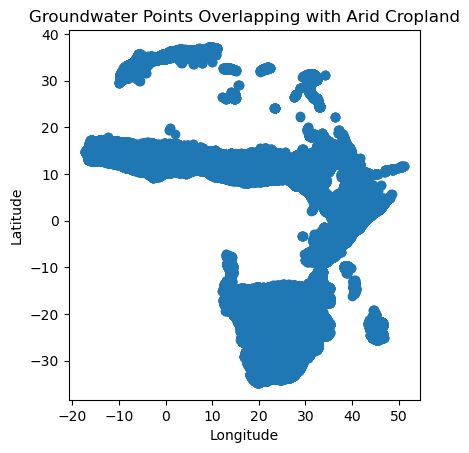

In [43]:
# Load the arid cropland raster data
with rasterio.open(resolve_path(config['Arid_Cropland_tif_path'])) as src:
    cropland_data = src.read(1)
    cropland_transform = src.transform

# Define a function to check if a point is within cropland
def is_in_cropland(point):
    x, y = point.x, point.y
    col, row = ~cropland_transform * (x, y)
    col, row = int(col), int(row)
    if 0 <= row < cropland_data.shape[0] and 0 <= col < cropland_data.shape[1]:
        return cropland_data[row, col] == 1
    return False

# Apply the function to filter points within cropland
gdf['in_cropland'] = gdf['geometry'].apply(is_in_cropland)
gdf_filtered = gdf[gdf['in_cropland']]
print(gdf_filtered.head())

gdf_groundwater = gdf_filtered.to_crs(epsg = 4326)

gdf_groundwater.to_file(resolve_path(config['Groundwater_Prod_Arid_Cropland_gpkg_path']))

# Plot the filtered points
gdf_filtered.plot()
plt.title('Groundwater Points Overlapping with Arid Cropland')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

#### Calculate the mean groundwater productivity for all arid cropland

In [58]:
# Read in groundwater and Cropland 
gdf_groundwater = gpd.read_file(resolve_path(config['Groundwater_Prod_Arid_Cropland_gpkg_path']))

with rasterio.open(resolve_path(config['Africa_Cropland_tif_path'])) as src:
     raw_cropland_data = src.read(1)
     raw_cropland_transform = src.transform
     raw_cropland_crs = src.crs

# Assure the same coordinate system
gdf_groundwater = gdf_groundwater.to_crs(raw_cropland_crs)

# Function to find the weighted value at a point and sum the weights
def weighted_mean_groundwater(row):
     global weight_sum
     x, y = row.geometry.x, row.geometry.y

     # convert coordinates to raster space
     col_idx, row_idx = ~raw_cropland_transform * (x, y)
     col_idx, row_idx = int(col_idx), int(row_idx)

    # Check if the point falls within the raster coverage
     if 0 <= row_idx < raw_cropland_data.shape[0] and 0 <= col_idx < raw_cropland_data.shape[1]:
        weight = raw_cropland_data[row_idx, col_idx]
        weight_sum = weight + weight_sum
        if not np.isnan(row['Liters_Second']):  # Check if Liters_Second is not NaN
            return row['Liters_Second'] * weight
     return np.nan

# Apply the function to each row in gdf_groundwater
weighted_values = gdf_groundwater.progress_apply(weighted_mean_groundwater, axis=1)

# Filter out NaN values from weighted_values
weighted_values = weighted_values.dropna()

# Check if there are valid values to calculate the mean
if len(weighted_values) > 0:
    weighted_values = np.array(weighted_values)
    weighted_sum = np.sum(weighted_values)
    #sum_weights = np.sum(weighted_values[:, 1])
    weighted_mean_groundwater_productivity = weighted_sum / weight_sum
    print(f"Weighted Mean Groundwater Productivity: {weighted_mean_groundwater_productivity} L/s")
else:
    print("No valid points found within raster coverage.")

100%|██████████| 264759/264759 [00:07<00:00, 35715.34it/s]

Weighted Mean Groundwater Productivity: 1.4212756273443117 L/s


In [56]:
# Calculate the targeting ratio
targeting_ratio = mean_groundwater_productivity / weighted_mean_groundwater_productivity
print(f"Targeting Ratio: {targeting_ratio}")

Targeting Ratio: 1.1209967376925507


#### Addressing Non-Linearity Issues

In [66]:
# Define the thresholds
thresholds = [0.1, 0.3, 0.75, 3.0, 12.5]

# Read the CPIS_groundwater data
CPIS_groundwater = gpd.read_file(resolve_path(config['CPIS_Groundwater_Prod_gpkg_path']))

# Loop through each threshold and calculate the percentages
for threshold in thresholds:
    # Filter CPIS_groundwater for Liters_Second values above the threshold
    CPIS_groundwater_above_threshold = CPIS_groundwater[CPIS_groundwater['Liters_Second'] > threshold]
    
    # Calculate the percentage of CPIS_groundwater that is above the threshold
    percent_above_threshold_CPIS = (len(CPIS_groundwater_above_threshold) / len(CPIS_groundwater)) * 100
    print(f"Percentage of CPIS groundwater production above {threshold} L/s: {percent_above_threshold_CPIS:.2f}%")
    
    # Filter gdf_groundwater for Liters_Second values above the threshold
    gdf_groundwater_above_threshold = gdf_groundwater[gdf_groundwater['Liters_Second'] > threshold]
    
    # Calculate the percentage of gdf_groundwater that is above the threshold
    percent_above_threshold_groundwater = (len(gdf_groundwater_above_threshold) / len(gdf_groundwater)) * 100
    print(f"Percentage of gdf_groundwater above {threshold} L/s: {percent_above_threshold_groundwater:.2f}%")

Percentage of CPIS groundwater production above 0.1 L/s: 99.07%
Percentage of gdf_groundwater above 0.1 L/s: 99.53%
Percentage of CPIS groundwater production above 0.3 L/s: 78.33%
Percentage of gdf_groundwater above 0.3 L/s: 80.90%
Percentage of CPIS groundwater production above 0.75 L/s: 37.15%
Percentage of gdf_groundwater above 0.75 L/s: 56.11%
Percentage of CPIS groundwater production above 3.0 L/s: 14.86%
Percentage of gdf_groundwater above 3.0 L/s: 28.50%
Percentage of CPIS groundwater production above 12.5 L/s: 3.72%
Percentage of gdf_groundwater above 12.5 L/s: 3.48%
